<font size=5>ConvHeads</font><br/>
<font size=10> Is the Driver Distracted?</font><br/>

Whether we are driving or in a passenger seat, we have seen drivers being distracted by a text on a phone, reaching behind for something, or having to attend a phone call.<br/>

According to [U.S Department of Transportation](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812926), Every day about 8 people in the United States are killed in crashes that are reported to involve a distracted driver.

We think that having a system that alerts the driver if they are distracted, is the need of the hour.

We intend to do this using Convolutional Neural Networks and classify the drivers actions into 10 classes- safe driving, texting - right,talking on the phone - right, texting - left, talking on the phone - left, operating the radio, drinking, reaching behind, hair and makeup, talking to passenger.

The contents of the notebook can be found below.
*   Part 1: Data exploration
*   Part 2: CNN model built and trained by us.
*   Part 3: EfficientNetB3 fine-tuned (Transfer learning)
*   Part 4: Visualisations
*   Part 5: Error Analysis
*   Part 6: Testing the model against data collected by us.
*   Part 7: Web-App Stream-lit

#### **Team members**: Sanivada Sai Chaitanya, Samyak Jain, Himanshu Kandapal, Aayush Birla.<br/>

# Part 1: Data exploration

In [ ]:
!pip3 -qq install tf_keras_vis 

In [ ]:
pip install visualkeras

In [ ]:
#importing neccesary libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from PIL import Image
import visualkeras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_Inceptionv3

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_input_IresnetV2

from tensorflow.keras.applications import EfficientNetB3

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

'\nfrom google.colab import files\nfiles.upload()\n'

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection -p /content/gdrive/My\ Drive/kaggle/state_driver

100% 3.99G/4.00G [01:14<00:00, 109MB/s]
100% 4.00G/4.00G [01:14<00:00, 57.5MB/s]


In [ ]:
#unzipping the data
os.chdir('/content/gdrive/My Drive/kaggle/state_driver')
!unzip state-farm-distracted-driver-detection.zip

In [ ]:
train_path="/content/gdrive/My Drive/train"

In [ ]:
classes_dict={
    0: "safe driving",
    1: "texting  right",
    2: "talking on the phone - right",
    3: "texting  left",
    4: "talking on the phone - left",
    5: "operating the radio",
    6: "drinking",
    7: "reaching behind",
    8: "hair and makeup",
    9: "talking to passenger",
}

In [ ]:
df_driver=pd.read_csv('/content/gdrive/MyDrive/kaggle/state_driver/driver_imgs_list.csv')
df_driver.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

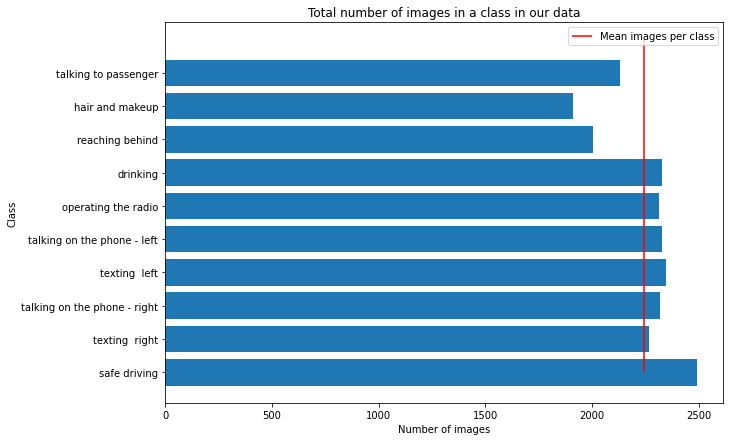

In [ ]:
plt.figure(figsize=(10,7))

plt.barh(pd.Series((df_driver.classname.value_counts().sort_index().index.str.slice(start=-1))).apply(lambda x: classes_dict[int(x)]),df_driver.classname.value_counts().sort_index())
plt.vlines(df_driver.classname.value_counts().mean(),0,10, color='red', label='Mean images per class')
plt.xlabel('Number of images')
plt.ylabel('Class')
plt.legend()
plt.title('Total number of images in a class in our data')
plt.show()

We can understand from the above bar plot that the images in the dataset are fairly distributed among all the classes.

In [ ]:
df_driver.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

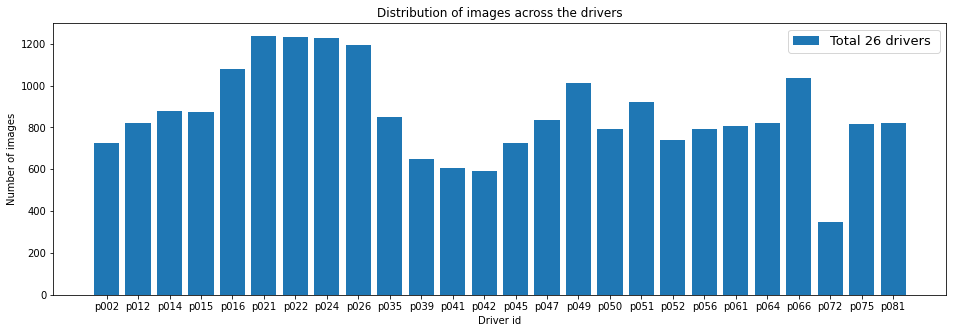

In [ ]:
plt.figure(figsize=(16,5))

plt.bar(df_driver.subject.value_counts().sort_index().index, df_driver.subject.value_counts().sort_index(), label=f'Total {(df_driver.subject.unique()).shape[0]} drivers ')
plt.xlabel('Driver id')
plt.ylabel('Number of images')
plt.legend(fontsize=13)
plt.title('Distribution of images across the drivers')

plt.show()

  ## Visualising the augmentations

In [ ]:
datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=False,width_shift_range=0.1, height_shift_range=0.1,shear_range=0.1,zoom_range=0.2,
                          validation_split=0.2)

train_gen=datagen.flow_from_directory(train_path, target_size=(240,320), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='training')

val_gen=datagen.flow_from_directory(train_path, target_size=(240,320), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='validation')

Found 17950 images belonging to 10 classes.
Found 4483 images belonging to 10 classes.


In [ ]:
sample_batch=train_gen.next()

sample_imgs=sample_batch[0]
sample_labels=sample_batch[1]

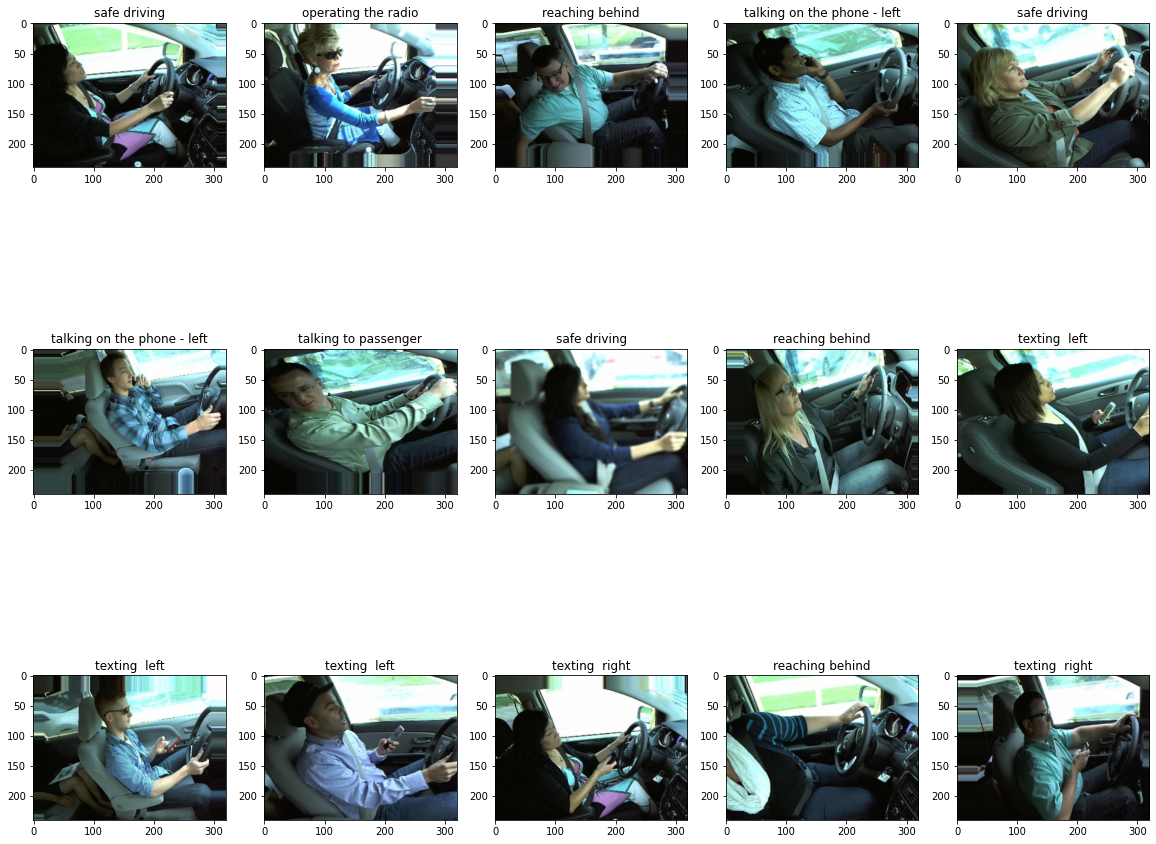

In [ ]:
fig, ax= plt.subplots( ncols=5, nrows=3, figsize=(20,17))

ax=ax.ravel()
for i,(ax) in enumerate(ax):
  ax.imshow(sample_imgs[i])
  ax.set_title(f'{classes_dict[(np.argmax(sample_labels[i]))]}')

# Part 2: CNN model built and trained by us.

In [ ]:
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen=datagen.flow_from_directory(directory = train_path, target_size=(64,64), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='training')

val_gen=datagen.flow_from_directory(directory = train_path, target_size=(64,64), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [ ]:
def create_model(img_rows, img_cols, color_type):
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(16,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(16,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [ ]:
model_scratch= create_model(64, 64, 3)

In [ ]:
model_scratch.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                        

In [ ]:
model_scratch.compile( loss='categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001), metrics='accuracy')

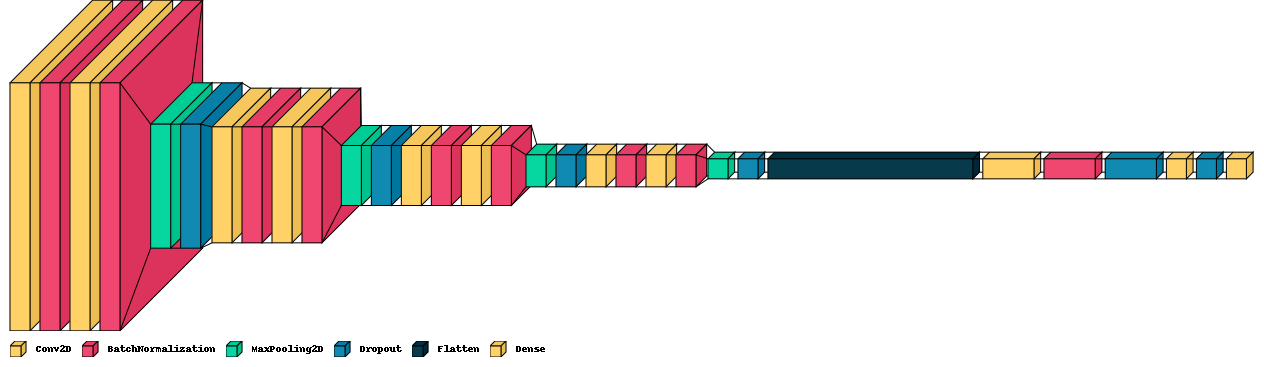

In [ ]:
visualkeras.layered_view(model_scratch,legend=True)

In [ ]:
history_scratch=model_scratch.fit(train_gen, epochs = 15, validation_data = val_gen, use_multiprocessing = True, workers = 8)

Epoch 1/15
561/561 [==============================] - 1338s 2s/step - loss: 2.0121 - accuracy: 0.3236 - val_loss: 1.4129 - val_accuracy: 0.4441
Epoch 2/15
561/561 [==============================] - 125s 217ms/step - loss: 0.9190 - accuracy: 0.6692 - val_loss: 0.4257 - val_accuracy: 0.8576
Epoch 3/15
561/561 [==============================] - 143s 252ms/step - loss: 0.5114 - accuracy: 0.8295 - val_loss: 0.2696 - val_accuracy: 0.9103
Epoch 4/15
561/561 [==============================] - 149s 263ms/step - loss: 0.3445 - accuracy: 0.8879 - val_loss: 0.2814 - val_accuracy: 0.9134
Epoch 5/15
561/561 [==============================] - 142s 251ms/step - loss: 0.2706 - accuracy: 0.9182 - val_loss: 0.1399 - val_accuracy: 0.9558
Epoch 6/15
561/561 [==============================] - 146s 258ms/step - loss: 0.2181 - accuracy: 0.9322 - val_loss: 0.0757 - val_accuracy: 0.9757
Epoch 7/15
561/561 [==============================] - 129s 228ms/step - loss: 0.1875 - accuracy: 0.9414 - val_loss: 0.0692 - v

In [ ]:
model_scratch.save('/content/gdrive/MyDrive/saved_models/model_scratch.h5')

In [ ]:
model_scratch.save_weights('/content/gdrive/MyDrive/saved_models/model_scratch.h5')

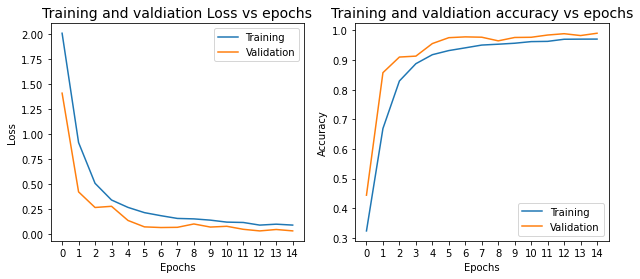

In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(10,4))

ax[0].plot(history_scratch.history['loss'], label='Training')
ax[0].plot(history_scratch.history['val_loss'], label='Validation')
ax[0].set_xticks(list(range(0,15)))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Training and valdiation Loss vs epochs', fontsize=14)

ax[1].plot(history_scratch.history['accuracy'], label='Training')
ax[1].plot(history_scratch.history['val_accuracy'], label='Validation')
ax[1].set_xticks(list(range(0,15)))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_title('Training and valdiation accuracy vs epochs', fontsize=14)

plt.show()

# Part 3: Fine-Tuning EfficientNetB3

In [ ]:
datagen=ImageDataGenerator(width_shift_range=0.3, height_shift_range=0.3,shear_range=0.3,zoom_range=0.4,
                           validation_split=0.2)

train_gen=datagen.flow_from_directory(train_path, target_size=(240,320), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='training')

val_gen=datagen.flow_from_directory(train_path, target_size=(240,320), color_mode='rgb',
                                      class_mode='categorical', batch_size=32, shuffle=True,
                                      subset='validation')

Found 17950 images belonging to 10 classes.
Found 4483 images belonging to 10 classes.


In [ ]:
base_model=EfficientNetB3(include_top=False, weights = 'imagenet', input_shape=(240,320,3))

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
x=base_model.output

x=keras.layers.GlobalAveragePooling2D()(x)

x=keras.layers.BatchNormalization()(x)

x=keras.layers.Dropout(0.2)(x)

preds=keras.layers.Dense(10, activation='softmax')(x)

In [ ]:
model=keras.Model(inputs=base_model.input, outputs=preds, name='using_EfficientNetB3')

In [ ]:
model.summary()

Model: "using_EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 320, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 320, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                               

Training all the layers with a lower learnig rate-1e-4.

In [ ]:
for layer in model.layers:
  layer.trainable=True

In [ ]:
model.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics='accuracy' )

In [ ]:
steps_per_epoch=17950 // 32
validation_steps=4483 // 32

In [ ]:
history=model.fit(train_gen, epochs=10, validation_data=val_gen,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps ,workers=8,use_multiprocessing=True)

Epoch 1/10
560/560 [==============================] - 1190s 2s/step - loss: 0.6408 - accuracy: 0.7945 - val_loss: 0.1215 - val_accuracy: 0.9654
Epoch 2/10
560/560 [==============================] - 1077s 2s/step - loss: 0.1484 - accuracy: 0.9535 - val_loss: 0.0970 - val_accuracy: 0.9699
Epoch 3/10
560/560 [==============================] - 1119s 2s/step - loss: 0.0999 - accuracy: 0.9716 - val_loss: 0.0612 - val_accuracy: 0.9812
Epoch 4/10
560/560 [==============================] - 1075s 2s/step - loss: 0.0643 - accuracy: 0.9787 - val_loss: 0.0535 - val_accuracy: 0.9824
Epoch 5/10
560/560 [==============================] - 1080s 2s/step - loss: 0.0604 - accuracy: 0.9807 - val_loss: 0.0435 - val_accuracy: 0.9871
Epoch 6/10
560/560 [==============================] - 1074s 2s/step - loss: 0.0506 - accuracy: 0.9843 - val_loss: 0.0302 - val_accuracy: 0.9893
Epoch 7/10
560/560 [==============================] - 1073s 2s/step - loss: 0.0389 - accuracy: 0.9875 - val_loss: 0.0408 - val_accuracy:

In [ ]:
model.save_weights('/content/gdrive/My Drive/kaggle/state_driver/model_EfficientNetB3_weights_only.h5')

In [ ]:
model_loaded=keras.models.load_model('/content/gdrive/My Drive/kaggle/state_driver/model_EfficientNetB3.h5')

In [ ]:
model.load_weights('/content/gdrive/My Drive/kaggle/state_driver/model_EfficientNetB3_weights_only.h5')

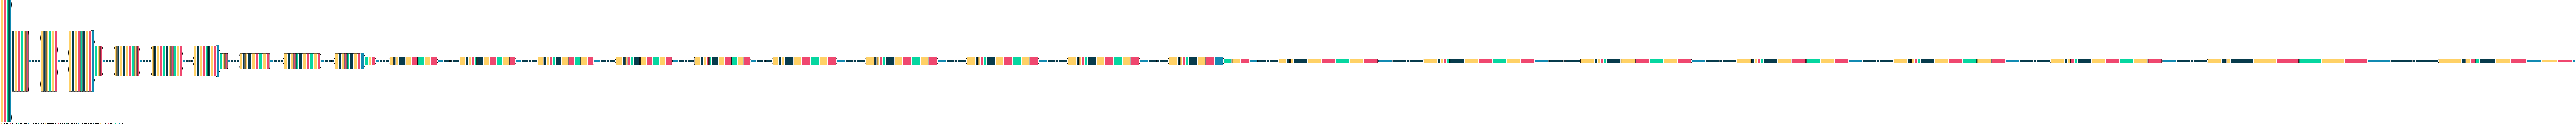

In [ ]:
visualkeras.layered_view(model,draw_volume=False ,legend=True)

We will be considering the fine-tuned EfficientNetB3 model for the visualisations and Error Analysis below, since this model seems to perform well.

# Part 4: Visualisations

#### Smooth-Grad and Grad-CAMs

In [ ]:
sample_batch=val_gen.next()

imgs=sample_batch[0]
labels=sample_batch[1]

In [ ]:
preds=model.predict(imgs)

correct_idx=np.where(np.argmax(labels, axis=1)==np.argmax(preds, axis=1))[0]
random_5_correct_idx=np.random.randint(0,correct_idx.shape[0], size=5)

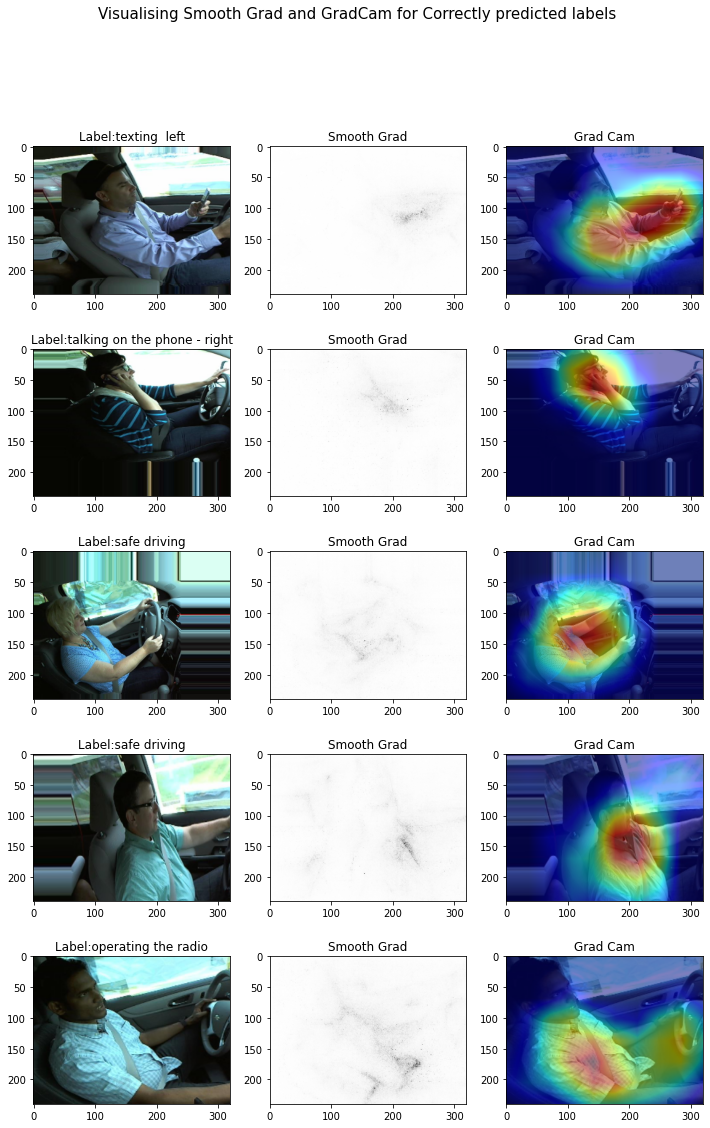

In [ ]:
r2l=ReplaceToLinear()

fig,ax=plt.subplots(ncols=3, nrows=5,figsize=(12,18))

for i,idx in enumerate(random_5_correct_idx):

  img=imgs[correct_idx[idx]]
  label=np.argmax(labels[correct_idx[idx]])

  score=CategoricalScore([label])

  saliency=Saliency(model, model_modifier=r2l, clone=True)
  saliency_map=saliency(score, img, smooth_samples=20, smooth_noise=0.2)
  saliency_map=normalize(saliency_map)

  grad_cam=Gradcam(model, model_modifier=r2l, clone=True)
  cam=grad_cam(score,img, penultimate_layer=-1)
  cam=normalize(cam)

  ax1=ax[i][0]
  ax2=ax[i][1]
  ax3=ax[i][2]

  ax1.imshow(img/255)
  ax1.set_title(f'Label:{classes_dict[label]}')

  ax2.imshow(saliency_map.reshape(240,320), cmap='Greys')
  ax2.set_title('Smooth Grad')

  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax3.imshow(img/255)
  ax3.imshow(heatmap.reshape(240,320,3), cmap='jet', alpha=0.5)
  ax3.set_title('Grad Cam')

fig.suptitle('Visualising Smooth Grad and GradCam for Correctly predicted labels', fontsize=15)

plt.show()

We can observe from the above Smooth-Grad and Grad-Cam plots of correctly predicted samples, that,


*   Except for one of five images, the model is looking at the right place to make the predictions.
*   But as we can see, for some images, the model is making correct predictions but the Class Activation maps are focused on a part other than what we percieve as the most important part of the image. 



#### Visualizing Dense layer using ActivationMaximization

In [ ]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress, PrintLogger
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

In [ ]:
seed_input = tf.random.uniform((10, 240, 320, 3), 0, 255)

In [ ]:
scores=CategoricalScore(list(range(0,10)))

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=r2l,
                                                 clone=True)
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

200/200 [==============================] - 150s 750ms/step - Score: 45.4210 - TotalVariation2D: 13.3445 - Norm: 33.7531


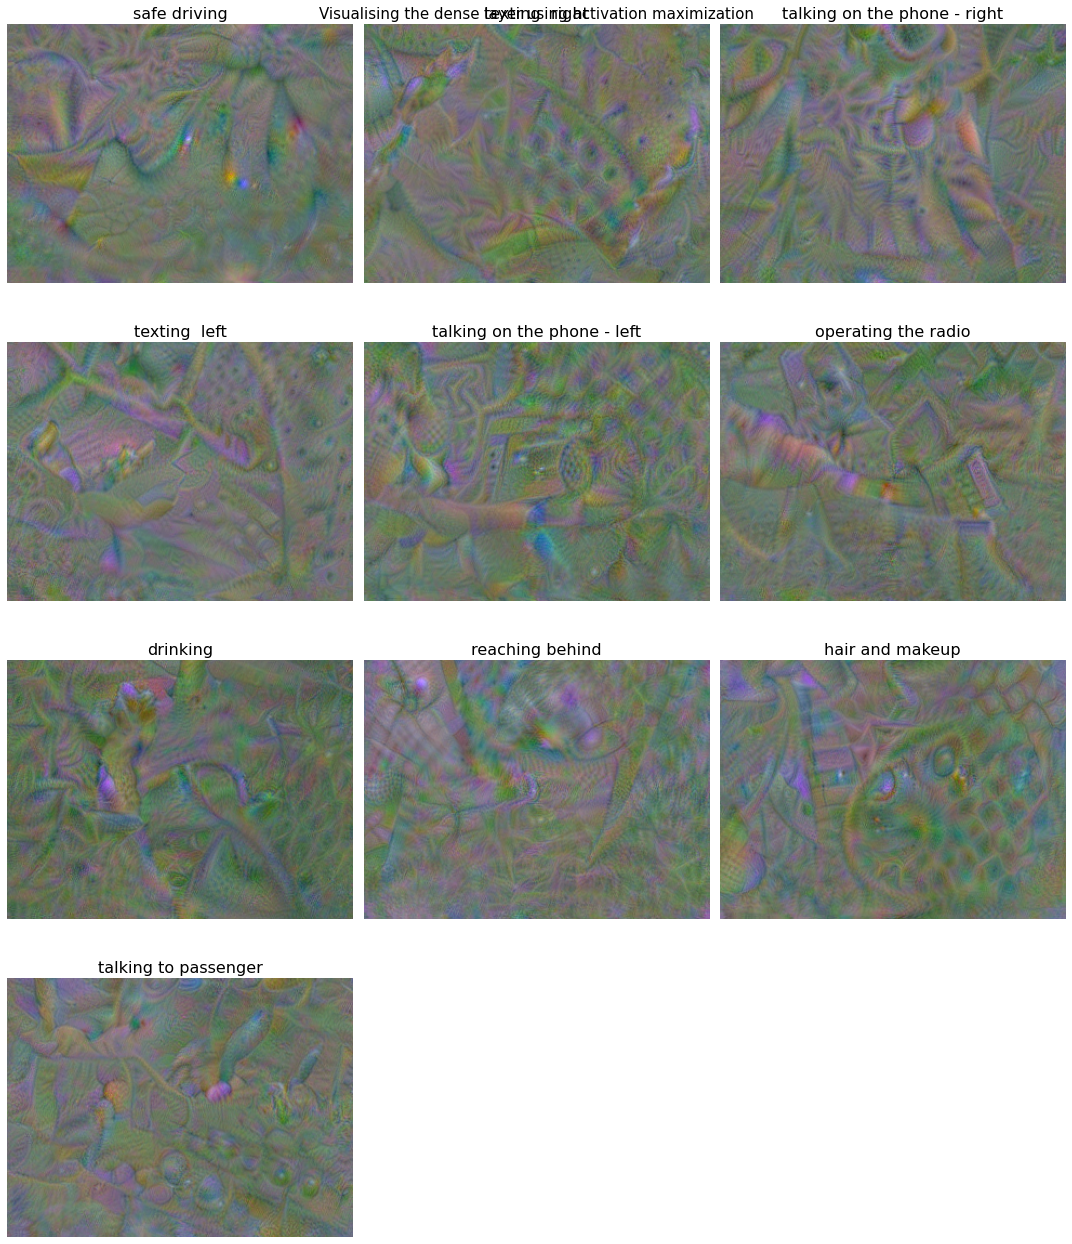

In [ ]:
fig=plt.figure(figsize=(15,18))

for i,label in enumerate(classes_dict.values()):
  ax=plt.subplot(4,3,i+1)
  ax.imshow(activations[i])
  ax.set_title(f'{label}', fontsize=16)
  ax.axis('off')

fig.suptitle('Visualising the dense layer using activation maximization', fontsize=15)
plt.tight_layout()
plt.show()


*   Since, the all the classes' images are in a car, the above plots are not much distinguishable.
*   But if we observe closely, we can slightly see that for a given class, there are some parts like hand operating a radio or hand reaching behind scattered all over.  



# Part 5: Error Analysis

In [ ]:
incorrect_imgs=np.zeros((0,240,320,3))
incorrect_og_labels=np.zeros((0,10))
incorrect_pred_labels=np.zeros((0,10))

for _ in range(40):
  sample_batch=val_gen.next()
  imgs_array=sample_batch[0]
  labels_array=sample_batch[1]

  preds=model.predict(imgs_array)

  incorrect_idx=np.where(np.argmax(preds, axis=1)!=np.argmax(labels_array, axis=1))[0]

  if incorrect_idx.shape !=(0,):
    incorrect_imgs=np.concatenate((incorrect_imgs, imgs_array[incorrect_idx]), axis=0)
    incorrect_og_labels=np.concatenate((incorrect_og_labels, labels_array[incorrect_idx]), axis=0)
    incorrect_pred_labels=np.concatenate((incorrect_pred_labels,preds[incorrect_idx]), axis=0)


In [ ]:
random_idx_5=np.random.randint(0,incorrect_imgs.shape[0], size=5)

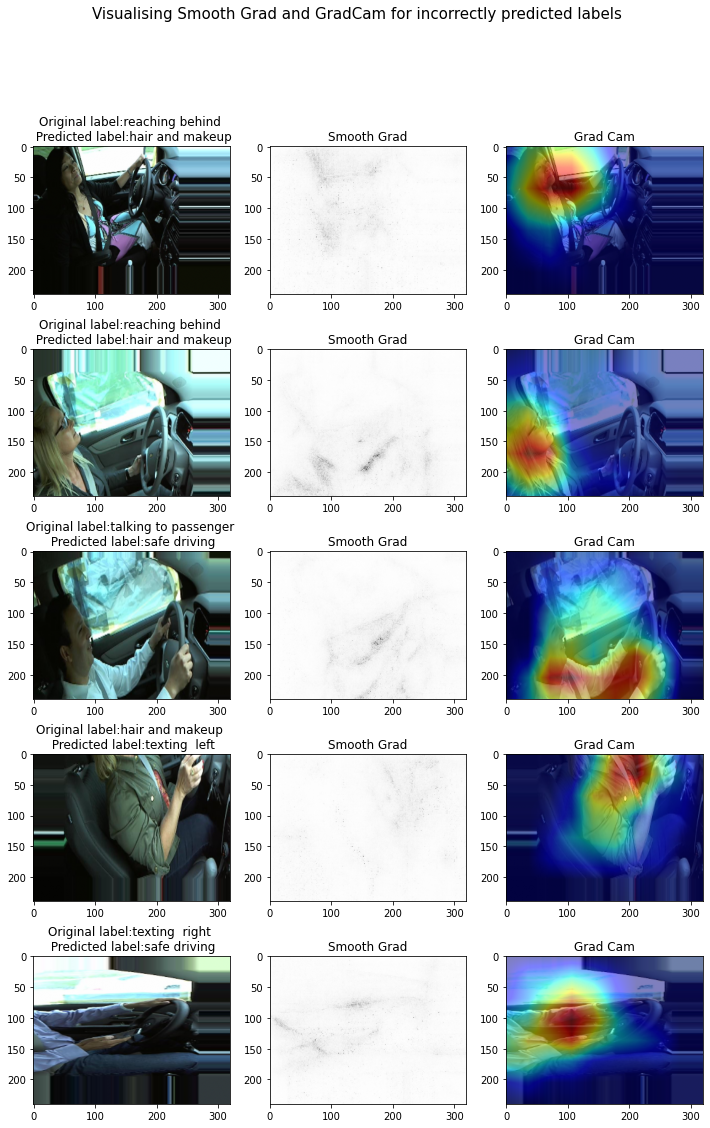

In [ ]:
r2l=ReplaceToLinear()

fig,ax=plt.subplots(ncols=3, nrows=5,figsize=(12,18))

for i,idx in enumerate(random_idx_5):

  img=incorrect_imgs[idx]
  label=np.argmax(incorrect_og_labels[idx])
  pred_label=np.argmax(incorrect_pred_labels[idx])

  score=CategoricalScore([pred_label])

  saliency=Saliency(model, model_modifier=r2l, clone=True)
  saliency_map=saliency(score, img, smooth_samples=20, smooth_noise=0.2)
  saliency_map=normalize(saliency_map)

  grad_cam=Gradcam(model, model_modifier=r2l, clone=True)
  cam=grad_cam(score,img, penultimate_layer=-1)
  cam=normalize(cam)

  ax1=ax[i][0]
  ax2=ax[i][1]
  ax3=ax[i][2]

  ax1.imshow(img/255)
  ax1.set_title(f'Original label:{classes_dict[label]} \n Predicted label:{classes_dict[pred_label]}')

  ax2.imshow(saliency_map.reshape(240,320), cmap='Greys')
  ax2.set_title('Smooth Grad')

  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax3.imshow(img/255)
  ax3.imshow(heatmap.reshape(240,320,3), cmap='jet', alpha=0.5)
  ax3.set_title('Grad Cam')

fig.suptitle('Visualising Smooth Grad and GradCam for incorrectly predicted labels', fontsize=15)

plt.show()

As we can observe from the Smooth-Grad and Saliency maps above, we can conclude that,


*   In most of above incorrectly predicted cases, the model is looking at the wrong part of the image to make the predictions.
*   This could be because the model could not differentiate some tiny differences in the image.  
*   Also, the augmentations we performed on the data have taken the most important part of the image to make the prediction out of the frame.
*   This would not be reproducible when we predict on non-augmented data. 



#  Part 6: Testing the model against data collected by us.
<font size=2>(Thanks to Samyak's father, we were able to collected some in-car images)</font><br/>
Since the training data is collected in a left-driving country (The United States) and our data is from a right-driving country (India). We had to flip the Images horizantally before feeding to the model.

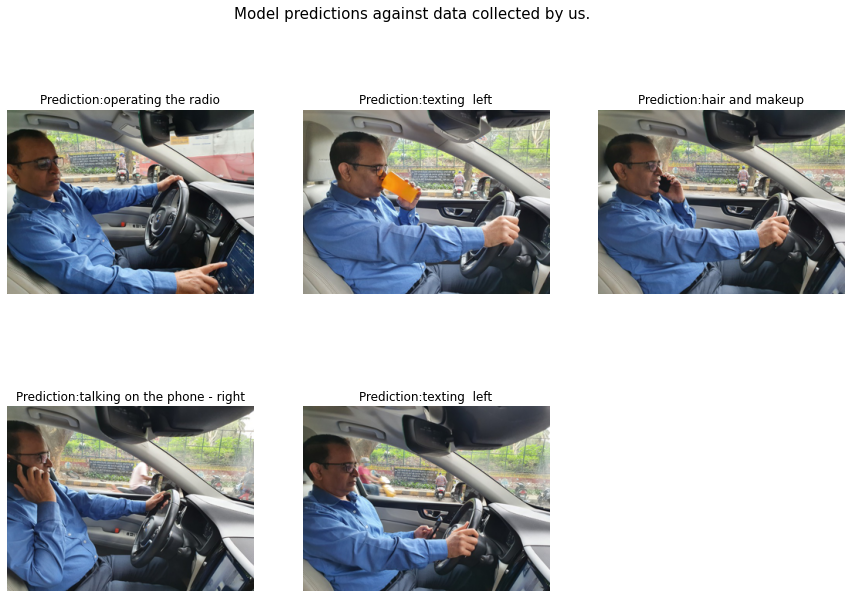

In [ ]:
fig=plt.figure(figsize=(15,10))

for i in range(1,6):
  img=Image.open(f'/content/gdrive/MyDrive/kaggle/state_driver/real_imgs/{i}.jpg')
  img=img.transpose(Image.FLIP_LEFT_RIGHT)
  img=img.resize((320,240))
  img_np=np.asarray(img)
  pred=classes_dict[(np.argmax(model.predict(np.expand_dims(img_np, axis=0))))]
  
  ax=plt.subplot(2,3,i)
  ax.imshow(img_np)
  ax.axis('off')
  ax.set_title(f'Prediction:{pred}')

fig.suptitle('Model predictions against data collected by us.', fontsize=15)
plt.show()

The model predicted 3 of the above 5 images correctly, but in the cases where the model predicted incorrectly, we can note that,


*   Since the training drinking class-images data consists of a single white colored starbucks-like cup. Our model could not detect the images with orange glass as drinking. Instead, it has predicted it as a texting on a phone.
*   The model can be improved if it is trained on more diverse data including data from more countries and drivers with wide range of age groups.




# Part 7: Web-App using Stream-lit
Please find the source code [here](https://www.dropbox.com/s/p4ugn0aryi7il83/Streamlit_webapp_AI2.zip?dl=0).